### Цирулев Н.В. М8О-408Б-22
# Лабораторная работа №4 (Проведение исследований со случайным лесом)

In [1]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import kagglehub

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, r2_score, root_mean_squared_error
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TEST_SIZE = 0.2

TUNE_N_CLF = 20000
CV_SPLITS_CLF = 2

CV_SPLITS_REG = 5


def eval_clf(y_true, y_pred, title: str):
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    print(f"\n=== {title} ===")
    print(f"precision: {precision:.6f}")
    print(f"recall:    {recall:.6f}")
    print(f"f1:        {f1:.6f}")

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=["legitimate(0)", "phishing(1)"]).plot(values_format="d")
    plt.title(title)
    plt.show()

    return {"precision": precision, "recall": recall, "f1": f1}


def eval_reg(y_true, y_pred, title: str):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {title} ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R2:   {r2:.5f}")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def load_from_kagglehub(dataset_id: str) -> pd.DataFrame:
    path = kagglehub.dataset_download(dataset_id)
    root = Path(path)
    csv_path = max(root.rglob("*.csv"), key=lambda p: p.stat().st_size)
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    print("Loaded:", dataset_id)
    print("CSV:", csv_path)
    print("Shape:", df.shape)
    return df


def parse_number(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan


def clean_laptop(df_in: pd.DataFrame) -> pd.DataFrame:
    dfc = df_in.copy()
    dfc.columns = dfc.columns.str.strip()

    for col in ["ram_gb", "ssd", "hdd", "graphic_card_gb", "os_bit", "rating", "processor_gnrtn"]:
        if col in dfc.columns:
            dfc[col] = dfc[col].map(parse_number)

    if "Price" in dfc.columns:
        dfc["Price"] = pd.to_numeric(dfc["Price"], errors="coerce")

    for col in ["Number of Ratings", "Number of Reviews"]:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc

c:\Users\WARMACHINE\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Имплементация алгоритма (случайный лес):

In [2]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import kagglehub

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

class DecisionTreeScratchHist:
    def __init__(
        self,
        task="classification",
        criterion="gini",
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        max_bins=64,
        random_state=42
    ):
        self.task = task
        self.criterion = criterion
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.max_bins = int(max_bins)
        self.random_state = int(random_state)
        self._rng = np.random.default_rng(self.random_state)

        self.n_features_ = None
        self.root_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y)
        self.n_features_ = X.shape[1]
        self.root_ = self._build(X, y, depth=0)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        out = np.empty(X.shape[0], dtype=np.float32 if self.task == "regression" else np.int32)
        for i in range(X.shape[0]):
            out[i] = self._predict_one(self.root_, X[i])
        return out.astype(np.int32) if self.task == "classification" else out

    def _predict_one(self, node, x):
        while not node["is_leaf"]:
            if x[node["feat"]] <= node["thr"]:
                node = node["left"]
            else:
                node = node["right"]
        return node["value"]

    def _stop(self, y, depth, n):
        if self.max_depth is not None and depth >= self.max_depth:
            return True
        if n < self.min_samples_split:
            return True
        if self.task == "classification":
            return np.all(y == y[0])
        return n <= 2

    def _leaf_value(self, y):
        if self.task == "classification":
            vals, cnts = np.unique(y, return_counts=True)
            return int(vals[np.argmax(cnts)])
        return float(np.mean(y)) if y.size else 0.0

    def _feature_subset(self):
        p = self.n_features_
        mf = self.max_features
        if mf is None:
            return np.arange(p)
        if isinstance(mf, str):
            if mf == "sqrt":
                k = max(1, int(np.sqrt(p)))
            elif mf == "log2":
                k = max(1, int(np.log2(p)))
            else:
                k = p
        elif isinstance(mf, float):
            k = max(1, int(p * mf))
        else:
            k = max(1, int(mf))
        k = min(p, k)
        return self._rng.choice(p, size=k, replace=False)

    def _impurity_clf(self, n0, n1):
        tot = n0 + n1
        if tot <= 0:
            return 0.0
        p0 = n0 / tot
        p1 = n1 / tot
        if self.criterion == "entropy":
            out = 0.0
            if p0 > 0:
                out -= p0 * np.log2(p0)
            if p1 > 0:
                out -= p1 * np.log2(p1)
            return float(out)
        return float(1.0 - (p0 * p0 + p1 * p1))

    def _best_split_clf(self, X, y):
        n, _ = X.shape
        y = y.astype(np.int32)

        total1 = int(y.sum())
        total0 = int(n - total1)

        best_feat = None
        best_thr = None
        best_score = np.inf

        feats = self._feature_subset()

        for j in feats:
            col = X[:, j]
            cmin = float(np.nanmin(col))
            cmax = float(np.nanmax(col))
            if not np.isfinite(cmin) or not np.isfinite(cmax) or cmin == cmax:
                continue

            is_binary = np.all((col == 0.0) | (col == 1.0))
            if is_binary:
                thr = 0.5
                left_mask = col <= thr
                nl = int(left_mask.sum())
                nr = n - nl
                if nl < self.min_samples_leaf or nr < self.min_samples_leaf:
                    continue
                yl = y[left_mask]
                left1 = int(yl.sum())
                left0 = nl - left1
                right1 = total1 - left1
                right0 = total0 - left0
                score = (nl / n) * self._impurity_clf(left0, left1) + (nr / n) * self._impurity_clf(right0, right1)
                if score < best_score:
                    best_score = score
                    best_feat = j
                    best_thr = float(thr)
                continue

            denom = (cmax - cmin) if (cmax > cmin) else 1.0
            bins = self.max_bins
            scaled = (col - cmin) / denom
            idx = np.floor(scaled * bins).astype(np.int32)
            idx = np.clip(idx, 0, bins - 1)

            cnt = np.bincount(idx, minlength=bins).astype(np.int32)
            ones = np.bincount(idx, weights=y, minlength=bins).astype(np.float64)

            left_cnt = np.cumsum(cnt)
            left_ones = np.cumsum(ones)
            right_cnt = n - left_cnt
            right_ones = total1 - left_ones

            valid = (left_cnt >= self.min_samples_leaf) & (right_cnt >= self.min_samples_leaf)
            if not np.any(valid):
                continue

            left1 = left_ones
            left0 = left_cnt - left1
            right1 = right_ones
            right0 = right_cnt - right1

            imp_left = np.vectorize(self._impurity_clf)(left0, left1)
            imp_right = np.vectorize(self._impurity_clf)(right0, right1)
            score_all = (left_cnt / n) * imp_left + (right_cnt / n) * imp_right
            score_all[~valid] = np.inf

            k = int(np.argmin(score_all))
            score = float(score_all[k])
            if np.isfinite(score) and score < best_score:
                thr = cmin + ((k + 1) / bins) * denom
                best_score = score
                best_feat = j
                best_thr = float(thr)

        return best_feat, best_thr

    def _best_split_reg(self, X, y):
        n, _ = X.shape
        y = y.astype(np.float32)

        best_feat = None
        best_thr = None
        best_score = np.inf

        feats = self._feature_subset()

        for j in feats:
            col = X[:, j]
            cmin = float(np.nanmin(col))
            cmax = float(np.nanmax(col))
            if not np.isfinite(cmin) or not np.isfinite(cmax) or cmin == cmax:
                continue

            is_binary = np.all((col == 0.0) | (col == 1.0))
            if is_binary:
                thr = 0.5
                left_mask = col <= thr
                nl = int(left_mask.sum())
                nr = n - nl
                if nl < self.min_samples_leaf or nr < self.min_samples_leaf:
                    continue
                yl = y[left_mask]
                yr = y[~left_mask]
                sse = float(((yl - yl.mean()) ** 2).sum() + ((yr - yr.mean()) ** 2).sum())
                if sse < best_score:
                    best_score = sse
                    best_feat = j
                    best_thr = float(thr)
                continue

            denom = (cmax - cmin) if (cmax > cmin) else 1.0
            bins = self.max_bins
            scaled = (col - cmin) / denom
            idx = np.floor(scaled * bins).astype(np.int32)
            idx = np.clip(idx, 0, bins - 1)

            cnt = np.bincount(idx, minlength=bins).astype(np.float64)
            sumy = np.bincount(idx, weights=y, minlength=bins).astype(np.float64)
            sumy2 = np.bincount(idx, weights=(y * y), minlength=bins).astype(np.float64)

            left_cnt = np.cumsum(cnt)
            left_sum = np.cumsum(sumy)
            left_sum2 = np.cumsum(sumy2)

            right_cnt = n - left_cnt
            right_sum = sumy.sum() - left_sum
            right_sum2 = sumy2.sum() - left_sum2

            valid = (left_cnt >= self.min_samples_leaf) & (right_cnt >= self.min_samples_leaf)
            if not np.any(valid):
                continue

            left_sse = left_sum2 - (left_sum * left_sum) / np.maximum(left_cnt, 1e-12)
            right_sse = right_sum2 - (right_sum * right_sum) / np.maximum(right_cnt, 1e-12)
            sse_all = left_sse + right_sse
            sse_all[~valid] = np.inf

            k = int(np.argmin(sse_all))
            score = float(sse_all[k])
            if np.isfinite(score) and score < best_score:
                thr = cmin + ((k + 1) / bins) * denom
                best_score = score
                best_feat = j
                best_thr = float(thr)

        return best_feat, best_thr

    def _build(self, X, y, depth):
        n = X.shape[0]
        if self._stop(y, depth, n):
            return {"is_leaf": True, "value": self._leaf_value(y)}

        if self.task == "classification":
            feat, thr = self._best_split_clf(X, y)
        else:
            feat, thr = self._best_split_reg(X, y)

        if feat is None or thr is None:
            return {"is_leaf": True, "value": self._leaf_value(y)}

        col = X[:, feat]
        left_mask = col <= thr
        nl = int(left_mask.sum())
        nr = n - nl
        if nl < self.min_samples_leaf or nr < self.min_samples_leaf:
            return {"is_leaf": True, "value": self._leaf_value(y)}

        Xl, yl = X[left_mask], y[left_mask]
        Xr, yr = X[~left_mask], y[~left_mask]

        return {
            "is_leaf": False,
            "feat": int(feat),
            "thr": float(thr),
            "left": self._build(Xl, yl, depth + 1),
            "right": self._build(Xr, yr, depth + 1),
        }
    
class RandomForestScratch:
    def __init__(
        self,
        task="classification",
        n_estimators=25,
        criterion="gini",
        max_depth=12,
        min_samples_split=2,
        min_samples_leaf=20,
        max_features="sqrt",
        bootstrap=True,
        max_samples=0.3,
        max_bins=64,
        random_state=42
    ):
        self.task = task
        self.n_estimators = int(n_estimators)
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.bootstrap = bool(bootstrap)
        self.max_samples = max_samples
        self.max_bins = int(max_bins)
        self.random_state = int(random_state)
        self._rng = np.random.default_rng(self.random_state)
        self.trees_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y)
        n = X.shape[0]
        if (self.max_samples is None) or (self.max_samples == 1) or (self.max_samples == 1.0):
            m = n
        else:
            m = int(np.ceil(float(self.max_samples) * n))
            m = max(1, min(n, m))

        self.trees_ = []
        for i in range(self.n_estimators):
            if self.bootstrap:
                idx = self._rng.integers(0, n, size=m, endpoint=False)
                Xi = X[idx]
                yi = y[idx]
            else:
                Xi = X
                yi = y
            tree = DecisionTreeScratchHist(
                task=self.task,
                criterion=self.criterion,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                max_bins=self.max_bins,
                random_state=self.random_state + 1000 + i
            )
            tree.fit(Xi, yi)
            self.trees_.append(tree)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        if self.task == "regression":
            preds = np.zeros(X.shape[0], dtype=np.float32)
            for t in self.trees_:
                preds += t.predict(X).astype(np.float32)
            preds /= max(1, len(self.trees_))
            return preds
        votes = np.zeros(X.shape[0], dtype=np.float32)
        for t in self.trees_:
            votes += t.predict(X).astype(np.float32)
        votes /= max(1, len(self.trees_))
        return (votes >= 0.5).astype(np.int32)

### Классификация

Loaded: ndarvind/phiusiil-phishing-url-dataset
CSV: C:\Users\WARMACHINE\.cache\kagglehub\datasets\ndarvind\phiusiil-phishing-url-dataset\versions\1\PhiUSIIL_Phishing_URL_Dataset.csv
Shape: (235795, 55)

=== baseline_sklearn_rf_clf ===
precision: 1.000000
recall:    0.999901
f1:        0.999950


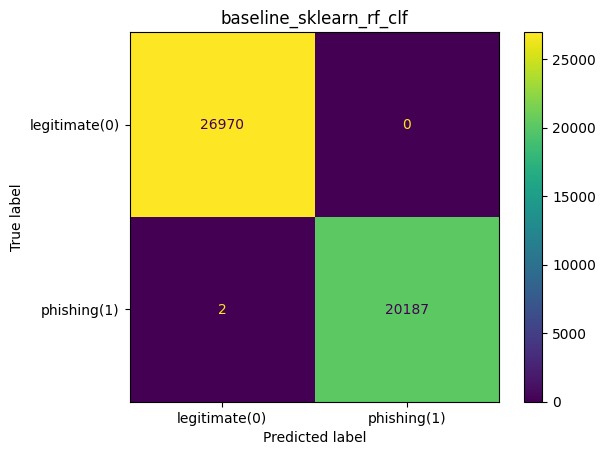

Fitting 2 folds for each of 216 candidates, totalling 432 fits

=== improved_sklearn_rf_clf ===
precision: 1.000000
recall:    0.999901
f1:        0.999950


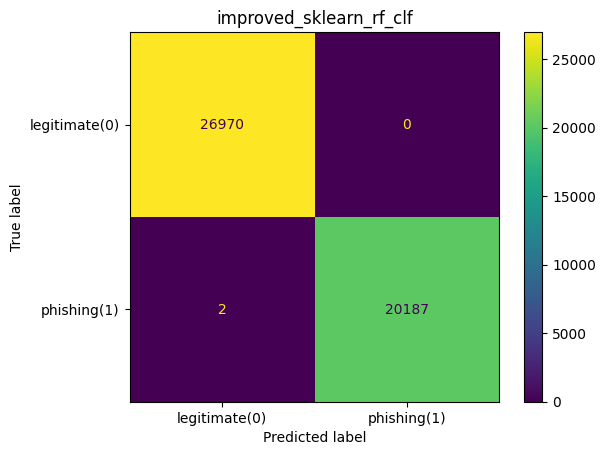


Best params (clf): {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 5, 'n_estimators': 50}

=== baseline_scratch_rf_clf ===
precision: 1.000000
recall:    0.999851
f1:        0.999926


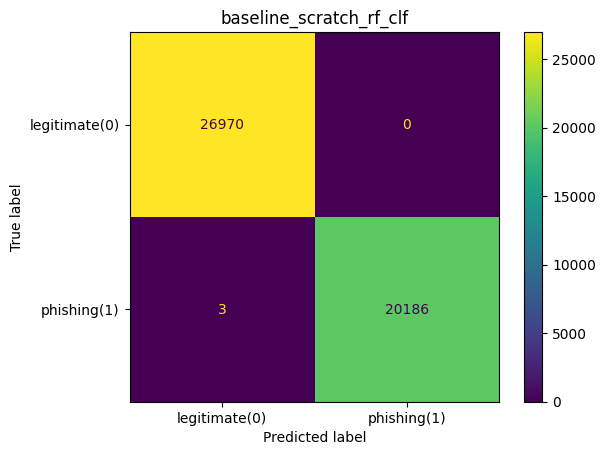


=== improved_scratch_rf_clf ===
precision: 1.000000
recall:    0.999901
f1:        0.999950


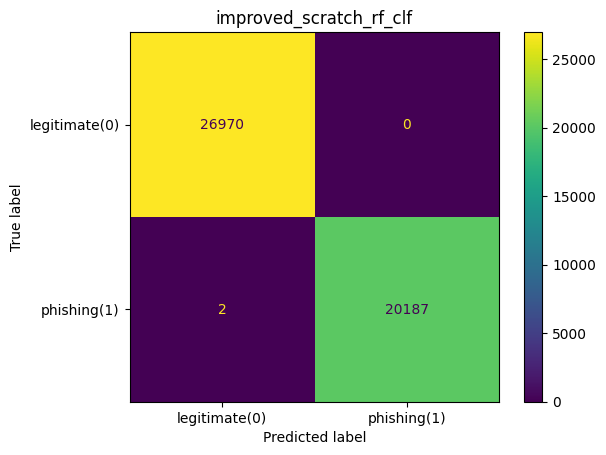


Classification comparison:


,precision,recall,f1
baseline_sklearn,1.0,0.999901,0.999950
improved_sklearn,1.0,0.999901,0.999950
baseline_scratch,1.0,0.999851,0.999926
improved_scratch,1.0,0.999901,0.999950


In [3]:
df_clf = load_from_kagglehub("ndarvind/phiusiil-phishing-url-dataset")

y_clf = (df_clf["label"] == 0).astype(int)
X_clf = df_clf.drop(columns=["label"])

text_cols_clf = [c for c in ["URL", "Domain", "TLD", "Title"] if c in X_clf.columns]
num_cols_clf = [c for c in X_clf.columns if c not in text_cols_clf]

X_train_clf_df, X_test_clf_df, y_train_clf, y_test_clf = train_test_split(
    X_clf[num_cols_clf], y_clf,
    test_size=TEST_SIZE,
    stratify=y_clf,
    random_state=RANDOM_STATE
)

X_train_clf = X_train_clf_df.to_numpy(dtype=np.float32)
X_test_clf = X_test_clf_df.to_numpy(dtype=np.float32)

rf_clf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_estimators=25,
    criterion="gini",
    max_depth=12,
    min_samples_leaf=20,
    min_samples_split=2,
    max_features="sqrt",
    bootstrap=True,
    max_samples=0.3,
    n_jobs=-1
)
rf_clf_base.fit(X_train_clf, y_train_clf)
pred_base_clf = rf_clf_base.predict(X_test_clf)
baseline_sklearn_clf = eval_clf(y_test_clf, pred_base_clf, "baseline_sklearn_rf_clf")

# Гипотезы: подбор n_estimators/max_depth/min_samples_leaf/max_features/max_samples/criterion по CV улучшит F1 за счёт баланса смещения/разброса и контроля сложности деревьев.
tune_n = min(TUNE_N_CLF, len(X_train_clf))
X_tune_clf, _, y_tune_clf, _ = train_test_split(
    X_train_clf, y_train_clf,
    train_size=tune_n,
    stratify=y_train_clf,
    random_state=RANDOM_STATE
)

param_grid_clf = {
    "n_estimators": [25, 50],
    "max_depth": [8, 12, 20],
    "min_samples_leaf": [1, 5, 20],
    "max_features": ["sqrt", 0.5],
    "max_samples": [0.2, 0.3, 0.5],
    "criterion": ["gini", "entropy"],
}

cv_clf = StratifiedKFold(n_splits=CV_SPLITS_CLF, shuffle=True, random_state=RANDOM_STATE)

search_clf = GridSearchCV(
    RandomForestClassifier(
        random_state=RANDOM_STATE,
        bootstrap=True,
        min_samples_split=2,
        n_jobs=-1
    ),
    param_grid=param_grid_clf,
    scoring="f1",
    refit=True,
    cv=cv_clf,
    n_jobs=-1,
    verbose=2
)
search_clf.fit(X_tune_clf, y_tune_clf)

best_rf_clf = search_clf.best_estimator_
best_rf_clf.fit(X_train_clf, y_train_clf)
pred_impr_clf = best_rf_clf.predict(X_test_clf)
improved_sklearn_clf = eval_clf(y_test_clf, pred_impr_clf, "improved_sklearn_rf_clf")

best_params_clf = search_clf.best_params_
print("\nBest params (clf):", best_params_clf)

scratch_base_clf = RandomForestScratch(
    task="classification",
    n_estimators=rf_clf_base.n_estimators,
    criterion=rf_clf_base.criterion,
    max_depth=rf_clf_base.max_depth,
    min_samples_split=rf_clf_base.min_samples_split,
    min_samples_leaf=rf_clf_base.min_samples_leaf,
    max_features=rf_clf_base.max_features,
    bootstrap=rf_clf_base.bootstrap,
    max_samples=rf_clf_base.max_samples,
    max_bins=64,
    random_state=RANDOM_STATE
)
scratch_base_clf.fit(X_train_clf, y_train_clf.to_numpy() if hasattr(y_train_clf, "to_numpy") else y_train_clf)
pred_s_base_clf = scratch_base_clf.predict(X_test_clf)
baseline_scratch_clf = eval_clf(y_test_clf, pred_s_base_clf, "baseline_scratch_rf_clf")

scratch_impr_clf = RandomForestScratch(
    task="classification",
    n_estimators=best_params_clf["n_estimators"],
    criterion=best_params_clf["criterion"],
    max_depth=best_params_clf["max_depth"],
    min_samples_split=2,
    min_samples_leaf=best_params_clf["min_samples_leaf"],
    max_features=best_params_clf["max_features"],
    bootstrap=True,
    max_samples=best_params_clf["max_samples"],
    max_bins=64,
    random_state=RANDOM_STATE
)
scratch_impr_clf.fit(X_train_clf, y_train_clf.to_numpy() if hasattr(y_train_clf, "to_numpy") else y_train_clf)
pred_s_impr_clf = scratch_impr_clf.predict(X_test_clf)
improved_scratch_clf = eval_clf(y_test_clf, pred_s_impr_clf, "improved_scratch_rf_clf")

compare_clf = pd.DataFrame(
    [baseline_sklearn_clf, improved_sklearn_clf, baseline_scratch_clf, improved_scratch_clf],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
print("\nClassification comparison:")
display(compare_clf)

#### Выводы по классификации

По результатам на тестовой выборке у sklearn-модели метрики уже на бейзлайне очень высокие: precision = 1.0, recall = 0.999901, f1 = 0.999950, и после улучшений значения не изменились (baseline_sklearn = improved_sklearn). Имплементация дала очень близкие результаты: на бейзлайне recall = 0.999851, f1 = 0.999926, а после “improved” поднялась до recall = 0.999901, f1 = 0.999950, то есть совпала по метрикам с improved_sklearn. В сумме это означает, что улучшения гиперпараметров в sklearn не дали прироста относительно уже сильного бейзлайна, а имплементация в улучшенном варианте воспроизвела качество библиотечной модели по ключевым метрикам.

### Регрессия

In [4]:
df_reg_raw = load_from_kagglehub("anubhavgoyal10/laptop-prices-dataset")
df_reg = clean_laptop(df_reg_raw).dropna(subset=["Price"]).reset_index(drop=True)

y_reg = df_reg["Price"].astype(float)
X_reg = df_reg.drop(columns=["Price"])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

num_cols_reg = [c for c in X_train_reg.columns if pd.api.types.is_numeric_dtype(X_train_reg[c])]
cat_cols_reg = [c for c in X_train_reg.columns if c not in num_cols_reg]

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

prep_reg = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_reg),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)]), cat_cols_reg),
    ],
    remainder="drop"
)

Xtr_reg_base = prep_reg.fit_transform(X_train_reg)
Xte_reg_base = prep_reg.transform(X_test_reg)

if hasattr(Xtr_reg_base, "toarray"):
    Xtr_reg_base = Xtr_reg_base.toarray()
    Xte_reg_base = Xte_reg_base.toarray()

Xtr_reg_base = np.asarray(Xtr_reg_base, dtype=np.float32)
Xte_reg_base = np.asarray(Xte_reg_base, dtype=np.float32)

rf_reg_base = RandomForestRegressor(
    random_state=RANDOM_STATE,
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1
)
rf_reg_base.fit(Xtr_reg_base, y_train_reg)
pred_base_reg = rf_reg_base.predict(Xte_reg_base)
baseline_sklearn_reg = eval_reg(y_test_reg, pred_base_reg, "baseline_sklearn_rf_reg")

# Гипотезы: подбор n_estimators/max_depth/min_samples_leaf/max_features/max_samples по CV улучшит MAE/RMSE/R2 за счёт контроля переобучения и усреднения ансамбля.
rf_pipe = Pipeline([
    ("prep", prep_reg),
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, bootstrap=True, n_jobs=-1)),
])

param_grid_reg = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [10, 15, None],
    "rf__min_samples_leaf": [1, 2, 5, 10],
    "rf__max_features": ["sqrt", 0.5],
    "rf__max_samples": [None, 0.8],
}

cv_reg = KFold(n_splits=CV_SPLITS_REG, shuffle=True, random_state=RANDOM_STATE)

search_reg = GridSearchCV(
    rf_pipe,
    param_grid=param_grid_reg,
    scoring="neg_mean_absolute_error",
    refit=True,
    cv=cv_reg,
    n_jobs=-1,
    verbose=2
)
search_reg.fit(X_train_reg, y_train_reg)

best_model_reg = search_reg.best_estimator_
pred_impr_reg = best_model_reg.predict(X_test_reg)
improved_sklearn_reg = eval_reg(y_test_reg, pred_impr_reg, "improved_sklearn_rf_reg")

best_params_reg = search_reg.best_params_
print("\nBest params (reg):", best_params_reg)

prep_reg_final = best_model_reg.named_steps["prep"]
Xtr_reg_impr = prep_reg_final.fit_transform(X_train_reg)
Xte_reg_impr = prep_reg_final.transform(X_test_reg)

if hasattr(Xtr_reg_impr, "toarray"):
    Xtr_reg_impr = Xtr_reg_impr.toarray()
    Xte_reg_impr = Xte_reg_impr.toarray()

Xtr_reg_impr = np.asarray(Xtr_reg_impr, dtype=np.float32)
Xte_reg_impr = np.asarray(Xte_reg_impr, dtype=np.float32)

scratch_base_reg = RandomForestScratch(
    task="regression",
    n_estimators=rf_reg_base.n_estimators,
    criterion="gini",
    max_depth=rf_reg_base.max_depth,
    min_samples_split=2,
    min_samples_leaf=rf_reg_base.min_samples_leaf,
    max_features=rf_reg_base.max_features,
    bootstrap=True,
    max_samples=1.0,
    max_bins=32,
    random_state=RANDOM_STATE
)
scratch_base_reg.fit(Xtr_reg_base, np.asarray(y_train_reg, dtype=np.float32))
pred_s_base_reg = scratch_base_reg.predict(Xte_reg_base)
baseline_scratch_reg = eval_reg(y_test_reg, pred_s_base_reg, "baseline_scratch_rf_reg")

rf_best = best_model_reg.named_steps["rf"]
scratch_impr_reg = RandomForestScratch(
    task="regression",
    n_estimators=int(rf_best.n_estimators),
    criterion="gini",
    max_depth=rf_best.max_depth,
    min_samples_split=int(rf_best.min_samples_split),
    min_samples_leaf=int(rf_best.min_samples_leaf),
    max_features=rf_best.max_features,
    bootstrap=bool(rf_best.bootstrap),
    max_samples=rf_best.max_samples,
    max_bins=32,
    random_state=RANDOM_STATE
)
scratch_impr_reg.fit(Xtr_reg_impr, np.asarray(y_train_reg, dtype=np.float32))
pred_s_impr_reg = scratch_impr_reg.predict(Xte_reg_impr)
improved_scratch_reg = eval_reg(y_test_reg, pred_s_impr_reg, "improved_scratch_rf_reg")

compare_reg = pd.DataFrame(
    [baseline_sklearn_reg, improved_sklearn_reg, baseline_scratch_reg, improved_scratch_reg],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
print("\nRegression comparison:")
display(compare_reg)


Loaded: anubhavgoyal10/laptop-prices-dataset
CSV: C:\Users\WARMACHINE\.cache\kagglehub\datasets\anubhavgoyal10\laptop-prices-dataset\versions\1\laptopPrice.csv
Shape: (823, 19)

=== baseline_sklearn_rf_reg ===
MAE:  12659.241
RMSE: 23387.433
R2:   0.71933
Fitting 5 folds for each of 96 candidates, totalling 480 fits

=== improved_sklearn_rf_reg ===
MAE:  11712.505
RMSE: 22645.432
R2:   0.73686

Best params (reg): {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__max_samples': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 400}

=== baseline_scratch_rf_reg ===
MAE:  12683.220
RMSE: 23817.251
R2:   0.70892

=== improved_scratch_rf_reg ===
MAE:  12232.931
RMSE: 23639.430
R2:   0.71325

Regression comparison:


,MAE,RMSE,R2
baseline_sklearn,12659.241229,23387.432962,0.719330
improved_sklearn,11712.505099,22645.431928,0.736857
baseline_scratch,12683.220490,23817.250635,0.708919
improved_scratch,12232.931132,23639.430166,0.713249


#### Выводы по регрессии

У sklearn-модели улучшение дало заметный, но умеренный прирост качества относительно бейзлайна: MAE снизился с 12659.241229 до 11712.505099, RMSE — с 23387.432962 до 22645.431928, R² вырос с 0.719330 до 0.736857. Scratch-реализация в целом повторяет тенденцию (улучшение лучше бейзлайна), но по абсолютным значениям уступает sklearn: baseline_scratch (MAE=12683.220490, RMSE=23817.250635, R2=0.708919) хуже baseline_sklearn, а improved_scratch (MAE=12232.931132, RMSE=23639.430166, R2=0.713249) улучшает бейзлайн scratch, но не достигает improved_sklearn. В итоге, тюнинг в sklearn действительно улучшил качество регрессии, а scratch-ансамбль воспроизводит общий эффект улучшения, но по метрикам остаётся слабее библиотечной реализации.